# - Import Library -


In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    GlobalAveragePooling2D, BatchNormalization
)
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers

# - Download Data -

In [ ]:
!pip install kaggle --upgrade

In [2]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"wejdanmjd","key":"464a8c15fc0537d20561911c50fc2309"}'}

In [7]:
!mkdir -p /root/.config/kaggle/

!mv "kaggle (1).json" /root/.config/kaggle/kaggle.json
!chmod 600 "/root/.config/kaggle/kaggle.json"

In [8]:
!kaggle competitions download -c sheep-classification-challenge-2025

  0% 0.00/34.7M [00:00<?, ?B/s]
100% 34.7M/34.7M [00:00<00:00, 1.51GB/s]


In [9]:
import zipfile

zip_path = '/content/sheep-classification-challenge-2025.zip'
extract_path = '/content/sheep_data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")
print(f"Available files: {os.listdir(extract_path)}")

Files extracted to: /content/sheep_data/
Available files: ['Sheep Classification Images']


In [10]:
image_dir = '/content/sheep_data/Sheep Classification Images/train'
classes = os.listdir(image_dir)
print(f"Available classes: {classes}")

Available classes: ['e4781659.jpg', '0d8abcaf.jpg', 'd037446e.jpg', '0c73a2d7.jpg', '46af9b12.jpg', 'cc916a6a.jpg', '946df06f.jpg', '2746da34.jpg', 'ca4064c5.jpg', '23846f27.jpg', 'e4a3dbaf.jpg', 'eec8b01e.jpg', 'b3188da6.jpg', '05597cba.jpg', '8e99b59b.jpg', '9cffbbf9.jpg', '58e03e24.jpg', 'fb16b218.jpg', '0f1dbdf9.jpg', '9173052b.jpg', '2f8f2979.jpg', '681f43d5.jpg', 'e508d376.jpg', '669de986.jpg', 'fd2e7fb2.jpg', '1c9c8931.jpg', '5c8bcb01.jpg', 'df2bd455.jpg', 'b3a99b06.jpg', '975f573e.jpg', '710d22dc.jpg', 'c4cd0238.jpg', '00e2f43f.jpg', '7dfac843.jpg', '16b31730.jpg', 'f8e5abb3.jpg', '58f975c5.jpg', '17d1d436.jpg', '8939e4f2.jpg', '40d944d9.jpg', 'dece6980.jpg', '9e32a296.jpg', 'e2127ded.jpg', 'd4e8a507.jpg', '3e896e52.jpg', '716a932b.jpg', '15a016f7.jpg', '69fbbd90.jpg', '3db832e2.jpg', '68ffd672.jpg', 'aed9e5ce.jpg', 'bdb8f65c.jpg', 'da3c0d9d.jpg', '8e31ff24.jpg', '3f71dd8e.jpg', 'c00da078.jpg', '0c0e1701.jpg', 'f3874874.jpg', 'dee6e096.jpg', 'e8e9810d.jpg', '4c50357f.jpg', '049

In [11]:
train_df = pd.read_csv('/content/sheep_data/Sheep Classification Images/train_labels.csv')

train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(image_dir, x))

train_df.head()

,filename,label,filepath
0,39d30b68.jpg,Naeimi,/content/sheep_data/Sheep Classification Image...
1,4a9853bd.jpg,Goat,/content/sheep_data/Sheep Classification Image...
2,d88facaa.jpg,Roman,/content/sheep_data/Sheep Classification Image...
3,a3f4f4af.jpg,Roman,/content/sheep_data/Sheep Classification Image...
4,16b31730.jpg,Naeimi,/content/sheep_data/Sheep Classification Image...


# - Exploratory Data Analysis -

In [12]:
# Display the number of images per class
class_counts = train_df['label'].value_counts()

# Print the result
print("Number of images per class:")
print(class_counts)

Number of images per class:
label
Naeimi     255
Goat       107
Sawakni     80
Roman       72
Najdi       71
Harri       62
Barbari     35
Name: count, dtype: int64


/tmp/ipython-input-3245073219.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


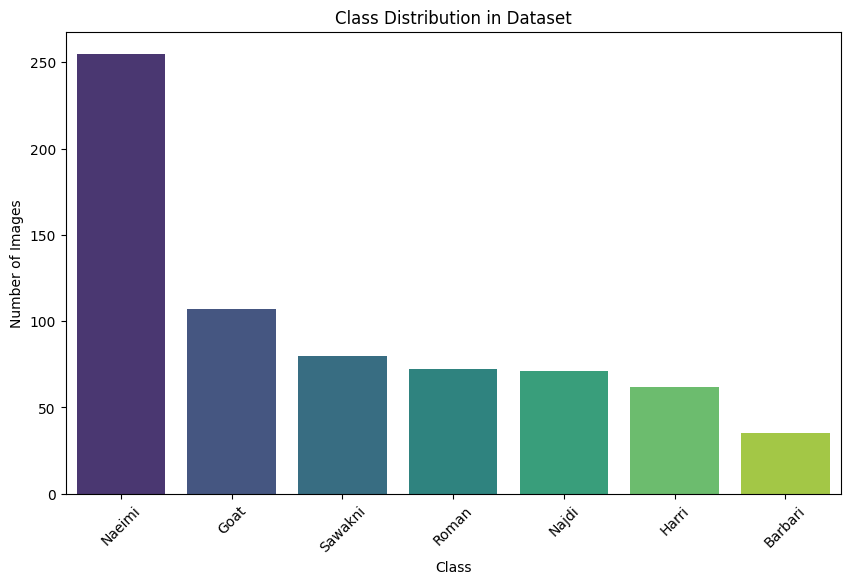

In [13]:
class_counts = train_df['label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title("Class Distribution in Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


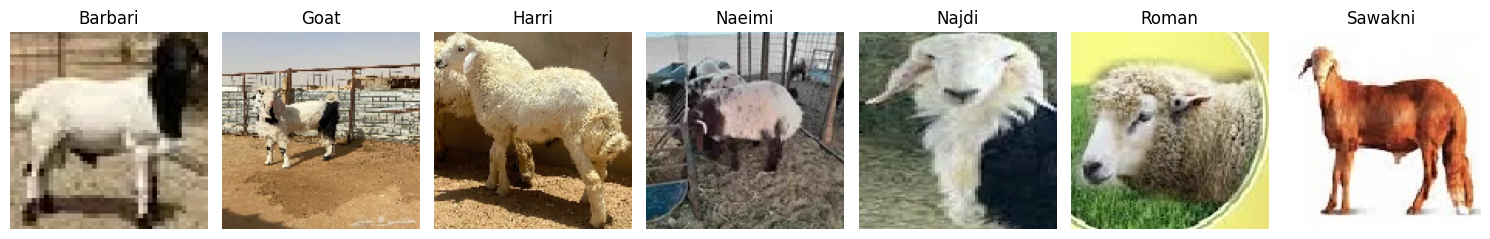

In [14]:
from tensorflow.keras.preprocessing import image


sample_per_class = train_df.groupby('label').sample(n=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 10))

for i, row in enumerate(sample_per_class.itertuples(), 1):
    img_path = row.filepath
    label = row.label

    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0

    plt.subplot(1, len(sample_per_class), i)
    plt.imshow(img_array)
    plt.title(f"{label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# - Image Preprocessing -

In [21]:
# split data (train_df) to : train_data_split , test_data_split
train_data_split, test_data_split = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)

# optimaize training with (ImageDataGenerator) it is a class from keras library
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.15
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Generate batches of augmented training images

# using the training split from the original DataFrame
train_data = train_datagen.flow_from_dataframe(
    train_data_split,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training',
)

val_data = train_datagen.flow_from_dataframe(
    train_data_split,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
)

test_data = test_datagen.flow_from_dataframe(
    test_data_split,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

Found 493 validated image filenames belonging to 7 classes.
Found 86 validated image filenames belonging to 7 classes.
Found 103 validated image filenames belonging to 7 classes.


### Assign higher weights to less frequent classes to handle imbalance, ensuring the model pays more attention to minority classes and improves overall accuracy by reducing bias toward majority classes.


In [22]:
print(train_data.class_indices)

{'Barbari': 0, 'Goat': 1, 'Harri': 2, 'Naeimi': 3, 'Najdi': 4, 'Roman': 5, 'Sawakni': 6}


In [23]:
samples_per_class = {
    0: 35,    # Barbari
    1: 107,   # Goat
    2: 62,    # Harri
    3: 255,   # Naeimi
    4: 71,    # Najdi
    5: 72,    # Roman
    6: 80     # Sawakni
}


In [24]:
total_samples = sum(samples_per_class.values())
num_classes = len(samples_per_class)

class_weights = {}
for class_index, samples in samples_per_class.items():
    class_weights[class_index] = total_samples / (num_classes * samples)

print("class_weights = ",class_weights)


class_weights =  {0: 2.783673469387755, 1: 0.910547396528705, 2: 1.5714285714285714, 3: 0.38207282913165264, 4: 1.3722334004024146, 5: 1.3531746031746033, 6: 1.2178571428571427}


# - Use Transfer learning **(MobileNet)** -

In [25]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(7, activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

model1.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,272,071 (8.67 MB)

 Trainable params: 11,527 (45.03 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

# -  This Line needs Strong GPU, Becareful ! -

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

history1 = model1.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - accuracy: 0.1831 - loss: 2.8711 - val_accuracy: 0.1047 - val_loss: 3.4291 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 680ms/step - accuracy: 0.1685 - loss: 2.7752 - val_accuracy: 0.0930 - val_loss: 3.0827 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 663ms/step - accuracy: 0.2170 - loss: 2.5113 - val_accuracy: 0.1047 - val_loss: 2.7992 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 601ms/step - accuracy: 0.2238 - loss: 2.5630 - val_accuracy: 0.1279 - val_loss: 2.6473 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 666ms/step - accuracy: 0.2273 - loss: 2.3423 - val_accuracy: 0.1628 - val_loss: 2.4829 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 674ms/step - accuracy: 0.1947 - loss: 2.2330 - val_accuracy: 0.1512 - val_loss: 2.2704 - learning_rate: 1.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 680ms/step - acc

# - Model Evaluation -

In [27]:
train_loss, train_acc = model1.evaluate(train_data)
print(f"Train Accuracy: {train_acc:.2f}")
print(f"Train Loss: {train_loss:.2f}")

val_loss, val_acc = model1.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

test_loss, test_acc = model1.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 586ms/step - accuracy: 0.4368 - loss: 1.4355
Train Accuracy: 0.44
Train Loss: 1.45
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.2975 - loss: 1.8380
Validation Accuracy: 0.34
Validation Loss: 1.76
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.3614 - loss: 1.5411
Test Accuracy: 0.36
Test Loss: 1.58


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 665ms/step
Classification Report:
              precision    recall  f1-score   support

     Barbari       0.18      0.40      0.25         5
        Goat       0.36      0.25      0.30        16
       Harri       0.29      0.44      0.35         9
      Naeimi       0.67      0.26      0.37        39
       Najdi       0.32      0.82      0.46        11
       Roman       0.20      0.18      0.19        11
     Sawakni       0.43      0.50      0.46        12

    accuracy                           0.36       103
   macro avg       0.35      0.41      0.34       103
weighted avg       0.45      0.36      0.35       103



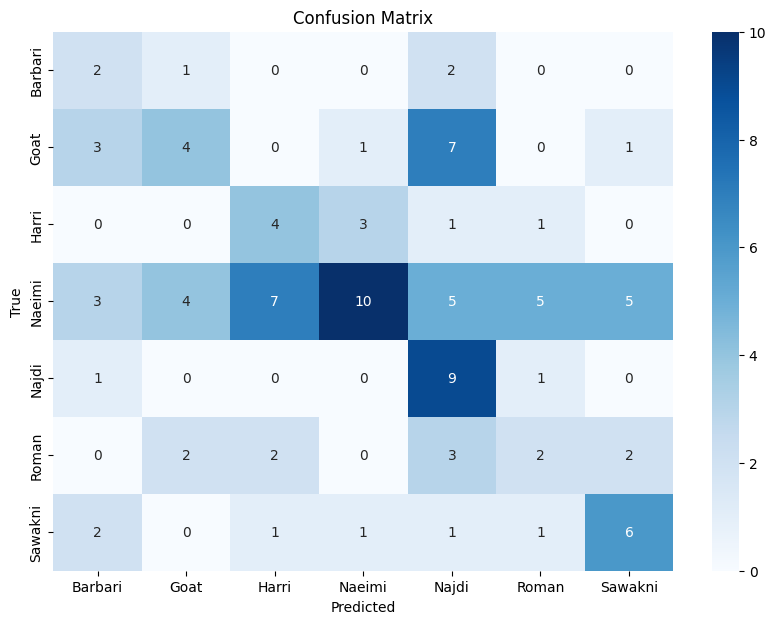

In [28]:
y_pred = model1.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_data.classes

class_indices = test_data.class_indices

index_to_class = {v: k for k, v in class_indices.items()}

class_names = [index_to_class[i] for i in range(len(index_to_class))]

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

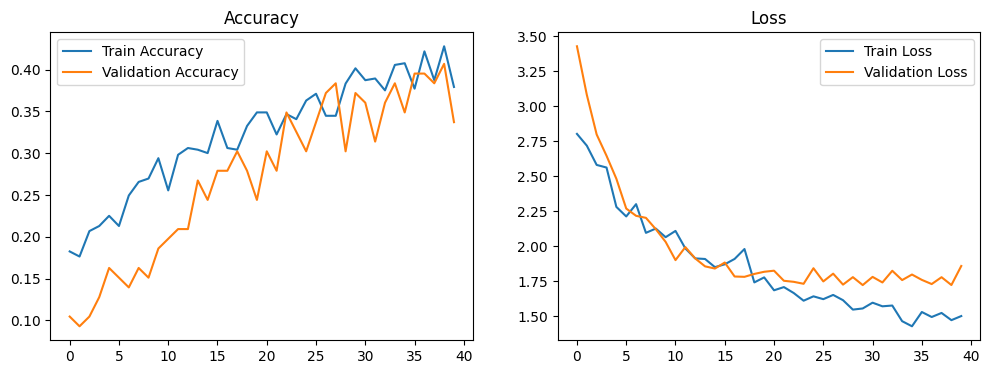

In [29]:
# Accuracy and loss curve
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# - Save Model 1 -

In [31]:
model1.save('/kaggle/working/Dal_model1.h5')

In [32]:
model1.save("Dal_model1.h5")

# - Model Evaluation and Visualization of Predictions -

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


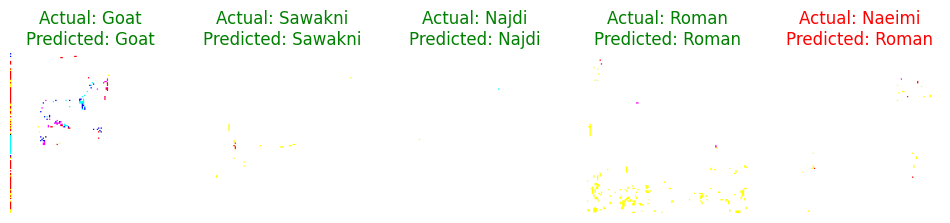

In [30]:
index_to_class = {v: k for k, v in class_indices.items()}

images, labels = next(test_data)

predictions = model1.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

predicted_labels = [index_to_class[idx] for idx in predicted_classes]

actual_classes = np.argmax(labels, axis=1)
actual_labels = [index_to_class[idx] for idx in actual_classes]

num_images = min(5, len(images))
plt.figure(figsize=(12, 6))

for i in range(num_images):
    img = images[i]

    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")

    color = "green" if actual_labels[i] == predicted_labels[i] else "red"
    plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}", color=color)

plt.show()